In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
import keras

C:\Users\Parker\Miniconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Loading and formatting the data
---

In [2]:
# Setting cute at index 1.  This will slightly simplify the final rating process
# since we can just average out the values.
CATEGORIES = ["subset-ugly", "subset-cute"]
DIRECTORY = "./Data/Images"

In [39]:
def transform_image(img):
    """
    Adds black padding around an image to make it square,
    then resizes to 96x96, then returns.
    """
    
    # I don't want to stretch the image, so I'll add padding to make it
    # square based on the largest dimension.
    dims = img.shape[:2]
    argmax_dim = np.argmax(dims)
    max_dim = dims[argmax_dim]

    # Shape is height, width, depth.  So, if argmax is 0 then height is max
    # and I should pad the left and right.  Opposite respectively for width.
    padding_amount = abs(np.diff(dims).item()) // 2

    padding_options = {
        0: {'top': 0, 'bottom': 0, 'left': padding_amount, 'right': padding_amount},
        1: {'top': padding_amount, 'bottom': padding_amount, 'left': 0, 'right': 0}
    }

    padding = padding_options[argmax_dim]

    # cv2.copyMakeBorder(src, top, bottom, left, right, method)
    padded = cv2.copyMakeBorder(img, **padding, borderType=cv2.BORDER_ISOLATED)

    resized = cv2.resize(padded, (96, 96))

    return resized

In [3]:
def create_dataset():
    dataset = []
    
    for category in CATEGORIES:
        path = os.path.join(DIRECTORY, category)

        # 0 is ugly, 1 is cute
        label = CATEGORIES.index(category)

        for filename in os.listdir(path):
            img = cv2.imread(os.path.join(path, filename))

            ### transformed = transform_image(img)
            # Trying out just resizing
            transformed = cv2.resize(img, (96, 96))
            
            dataset.append((transformed, label))
            
    return dataset

In [4]:
dataset = create_dataset()
len(dataset)

2000

In [5]:
# Shuffle the dataset
random.shuffle(dataset)

In [6]:
X = []
y = []

for data, label in dataset:
    X.append(data)
    y.append(label)
    
X = np.array(X).reshape(-1, 96, 96, 3) # 3 channels, rgb

In [7]:
import pickle

with open("sub-X.pickle", 'wb') as pickle_out:
    pickle.dump(X, pickle_out)

with open("sub-y.pickle", 'wb') as pickle_out:
    pickle.dump(y, pickle_out)

# Commence training
---

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization

In [9]:
with open("sub-X.pickle", 'rb') as pickle_in:
    X = pickle.load(pickle_in)
    
with open("sub-y.pickle", 'rb') as pickle_in:
    y = pickle.load(pickle_in)

In [10]:
X = X / 255

In [11]:
X.shape

(2000, 96, 96, 3)

Incredible help (and copy paste) from https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/.

In [18]:
model = Sequential()

chanDim = -1

# CONV => RELU => POOL
model.add(Conv2D(32, (3, 3), padding="same",
    input_shape=(96, 96, 3)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# softmax classifier
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X, y, batch_size=128, validation_split=0.2, epochs=30)

Train on 1600 samples, validate on 400 samples
Epoch 1/30
1600/1600 [==============================] - 8s 5ms/step - loss: 1.1021 - acc: 0.5825 - val_loss: 1.0363 - val_acc: 0.6075
Epoch 2/30
1600/1600 [==============================] - 3s 2ms/step - loss: 0.7210 - acc: 0.6837 - val_loss: 1.0000 - val_acc: 0.6475
Epoch 3/30
1600/1600 [==============================] - 3s 2ms/step - loss: 0.6119 - acc: 0.7162 - val_loss: 0.8829 - val_acc: 0.6450
Epoch 4/30
1600/1600 [==============================] - 3s 2ms/step - loss: 0.5484 - acc: 0.7400 - val_loss: 0.7810 - val_acc: 0.6750
Epoch 5/30
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4781 - acc: 0.7756 - val_loss: 0.9676 - val_acc: 0.6900
Epoch 6/30
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4430 - acc: 0.8044 - val_loss: 0.7388 - val_acc: 0.6975
Epoch 7/30
1600/1600 [==============================] - 3s 2ms/step - loss: 0.4091 - acc: 0.8188 - val_loss: 0.7099 - val_acc: 0.6850
Epoch 8/30
1600

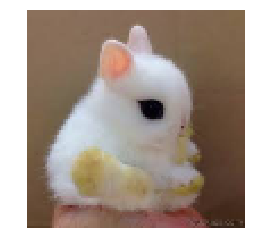

In [126]:
plt.axis("off")
plt.imshow(cv2.cvtColor(X[random.choice(range(2000))].astype(np.float32), cv2.COLOR_BGR2RGB))

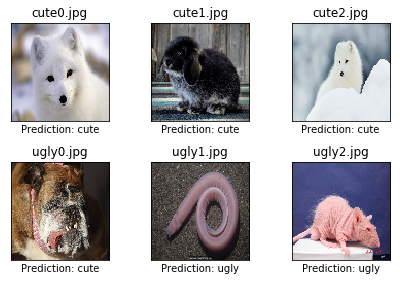

In [47]:
path = "./Test"

# plt.subplots(constrained_layout=True)
# subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

for i, filename in enumerate(os.listdir(path)):
    img = cv2.imread(os.path.join(path, filename))
    transformed = cv2.resize(img, (96, 96))
    
    to_predict = transformed.reshape(-1, 96, 96, 3)
    prediction = model.predict_classes(to_predict)
    pred = "cute" if prediction else "ugly"
    
    ax = plt.subplot(2, 3, i+1)
    plt.title(filename)
    ax.set_xlabel("Prediction: {}".format(pred))
    ax.set_xticks([])
    ax.set_yticks([])
#     plt.axis("off")
    plt.imshow(cv2.cvtColor(transformed, cv2.COLOR_BGR2RGB))
    
#     print("Name: {}\nPrediction: {}".format(filename, pred))

plt.tight_layout()